In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=15, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 19s 811ms/step - loss: 0.6997 - acc: 0.6101 - val_loss: 0.4851 - val_acc: 0.7593
Epoch 2/100
24/24 [==============================] - 14s 588ms/step - loss: 0.4994 - acc: 0.7411 - val_loss: 0.3702 - val_acc: 0.8333
Epoch 3/100
24/24 [==============================] - 14s 589ms/step - loss: 0.4584 - acc: 0.8022 - val_loss: 0.3376 - val_acc: 0.8580
Epoch 4/100
24/24 [==============================] - 14s 591ms/step - loss: 0.3839 - acc: 0.8394 - val_loss: 0.2862 - val_acc: 0.8889
Epoch 5/100
24/24 [==============================] - 14s 593ms/step - loss: 0.3448 - acc: 0.8565 - val_loss: 0.2684 - val_acc: 0.8951
Epoch 6/100
24/24 [==============================] - 14s 594ms/step - loss: 0.3231 - acc: 0.8616 - val_loss: 0.2634 - val_acc: 0.8765
Epoch 7/100
24/24 [==============================] - 14s 593ms/step - loss: 0.2637 - acc: 0.8877 - val_loss: 0.2428 - val_acc: 0.9198
Epoch 8/100
24/24 [===============

24/24 [==============================] - 13s 524ms/step - loss: 0.1905 - acc: 0.9214 - val_loss: 0.1768 - val_acc: 0.9193
Epoch 25/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1645 - acc: 0.9297 - val_loss: 0.1819 - val_acc: 0.9379
Epoch 26/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1529 - acc: 0.9410 - val_loss: 0.1698 - val_acc: 0.9255
Epoch 27/100
24/24 [==============================] - 13s 521ms/step - loss: 0.1298 - acc: 0.9418 - val_loss: 0.2462 - val_acc: 0.9130
Epoch 28/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1222 - acc: 0.9468 - val_loss: 0.2470 - val_acc: 0.9379
Epoch 29/100
24/24 [==============================] - 13s 521ms/step - loss: 0.1390 - acc: 0.9397 - val_loss: 0.2624 - val_acc: 0.9130
Epoch 30/100
24/24 [==============================] - 12s 520ms/step - loss: 0.1594 - acc: 0.9259 - val_loss: 0.1993 - val_acc: 0.9068
Train loss: 0.166950000857
Train accuracy: 0.925155925156
Test loss:

Epoch 12/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2048 - acc: 0.9169 - val_loss: 0.2780 - val_acc: 0.8750
Epoch 13/100
24/24 [==============================] - 13s 523ms/step - loss: 0.2452 - acc: 0.8901 - val_loss: 0.2888 - val_acc: 0.8750
Epoch 14/100
24/24 [==============================] - 14s 603ms/step - loss: 0.2543 - acc: 0.8912 - val_loss: 0.1978 - val_acc: 0.9125
Epoch 15/100
24/24 [==============================] - 15s 606ms/step - loss: 0.2474 - acc: 0.8876 - val_loss: 0.1886 - val_acc: 0.9187
Epoch 16/100
24/24 [==============================] - 13s 523ms/step - loss: 0.2152 - acc: 0.9122 - val_loss: 0.2163 - val_acc: 0.9187
Epoch 17/100
24/24 [==============================] - 13s 522ms/step - loss: 0.1826 - acc: 0.9243 - val_loss: 0.2531 - val_acc: 0.9187
Epoch 18/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1958 - acc: 0.9147 - val_loss: 0.2159 - val_acc: 0.9187
Epoch 19/100
24/24 [==============================] - 1

Train loss: 0.175474767375
Train accuracy: 0.925900277008
Test loss: 0.15249427706
Test accuracy: 0.95625

===================FOLD= 5
Epoch 1/100
24/24 [==============================] - 17s 691ms/step - loss: 0.7033 - acc: 0.6265 - val_loss: 0.4350 - val_acc: 0.7750
Epoch 2/100
24/24 [==============================] - 14s 603ms/step - loss: 0.4995 - acc: 0.7625 - val_loss: 0.3626 - val_acc: 0.8688
Epoch 3/100
24/24 [==============================] - 14s 602ms/step - loss: 0.4166 - acc: 0.8194 - val_loss: 0.3437 - val_acc: 0.8750
Epoch 4/100
24/24 [==============================] - 14s 603ms/step - loss: 0.3453 - acc: 0.8480 - val_loss: 0.3280 - val_acc: 0.8562
Epoch 5/100
24/24 [==============================] - 13s 522ms/step - loss: 0.3709 - acc: 0.8424 - val_loss: 0.3418 - val_acc: 0.8625
Epoch 6/100
24/24 [==============================] - 14s 602ms/step - loss: 0.3084 - acc: 0.8625 - val_loss: 0.2495 - val_acc: 0.9125
Epoch 7/100
24/24 [==============================] - 14s 603ms

Epoch 22/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1598 - acc: 0.9396 - val_loss: 0.2765 - val_acc: 0.8562
Epoch 23/100
24/24 [==============================] - 12s 519ms/step - loss: 0.1606 - acc: 0.9361 - val_loss: 0.3148 - val_acc: 0.8938
Epoch 24/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1596 - acc: 0.9336 - val_loss: 0.2849 - val_acc: 0.8750
Epoch 25/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1638 - acc: 0.9291 - val_loss: 0.2626 - val_acc: 0.8750
Epoch 26/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1395 - acc: 0.9443 - val_loss: 0.3635 - val_acc: 0.8625
Epoch 27/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1534 - acc: 0.9419 - val_loss: 0.2679 - val_acc: 0.9062
Epoch 28/100
24/24 [==============================] - 15s 605ms/step - loss: 0.1287 - acc: 0.9441 - val_loss: 0.2400 - val_acc: 0.9125
Epoch 29/100
24/24 [==============================] - 1

Epoch 39/100
24/24 [==============================] - 13s 521ms/step - loss: 0.1761 - acc: 0.9236 - val_loss: 0.3679 - val_acc: 0.8438
Epoch 40/100
24/24 [==============================] - 12s 520ms/step - loss: 0.1642 - acc: 0.9428 - val_loss: 0.1640 - val_acc: 0.9313
Epoch 41/100
24/24 [==============================] - 13s 521ms/step - loss: 0.1234 - acc: 0.9498 - val_loss: 0.1949 - val_acc: 0.9313
Epoch 42/100
24/24 [==============================] - 12s 518ms/step - loss: 0.1210 - acc: 0.9438 - val_loss: 0.2200 - val_acc: 0.9313
Epoch 43/100
24/24 [==============================] - 12s 518ms/step - loss: 0.1261 - acc: 0.9476 - val_loss: 0.2308 - val_acc: 0.9125
Epoch 44/100
24/24 [==============================] - 12s 518ms/step - loss: 0.1179 - acc: 0.9531 - val_loss: 0.2671 - val_acc: 0.9250
Epoch 45/100
24/24 [==============================] - 13s 522ms/step - loss: 0.1440 - acc: 0.9410 - val_loss: 0.2299 - val_acc: 0.9000
Epoch 46/100
24/24 [==============================] - 1

Epoch 28/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1503 - acc: 0.9445 - val_loss: 0.2291 - val_acc: 0.9000
Epoch 29/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1693 - acc: 0.9342 - val_loss: 0.2356 - val_acc: 0.9000
Epoch 30/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1361 - acc: 0.9456 - val_loss: 0.1845 - val_acc: 0.9250
Epoch 31/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1096 - acc: 0.9612 - val_loss: 0.2983 - val_acc: 0.8750
Epoch 32/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1331 - acc: 0.9482 - val_loss: 0.2664 - val_acc: 0.8938
Epoch 33/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1435 - acc: 0.9430 - val_loss: 0.2655 - val_acc: 0.9000
Epoch 34/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1394 - acc: 0.9524 - val_loss: 0.2279 - val_acc: 0.9062
Train loss: 0.117981522801
Train accuracy: 0.9515235457

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_15p_copy.csv', index=False)

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


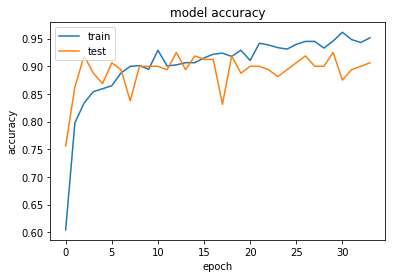

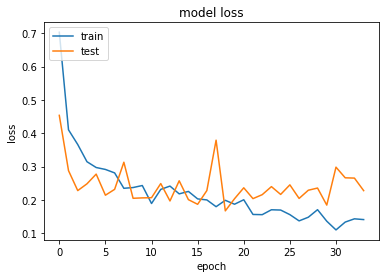

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

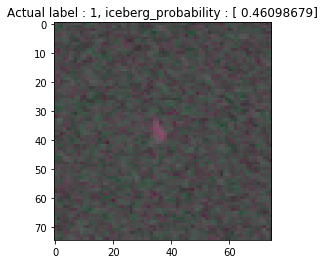

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

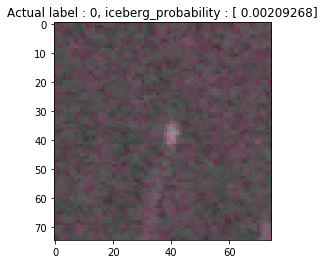

In [18]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

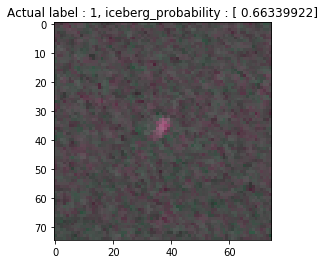

In [19]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

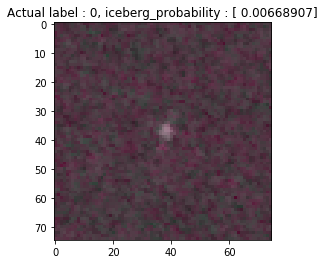

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

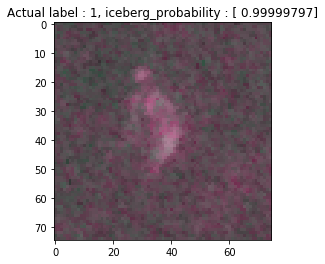

In [21]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

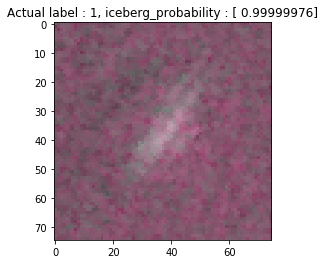

In [22]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

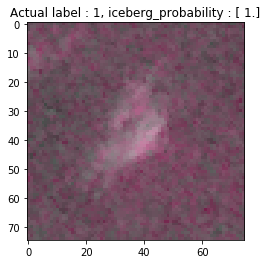

In [23]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

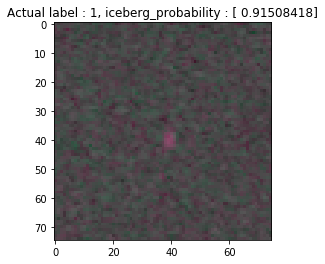

In [24]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

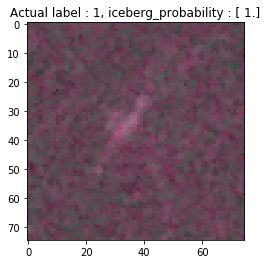

In [25]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

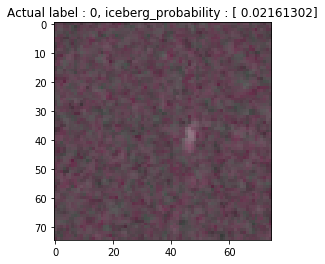

In [26]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)